ACISpy provides the ability to run [Xija](http://cxc.cfa.harvard.edu/mta/ASPECT/tool_doc/xija/index.html) thermal models via a special class, `ThermalModelRunner`, which can input commanded states from a variety of sources. The really nice thing about `ThermalModelRunner` is that it is actually a `Dataset` object, so we can look at the different fields, make plots, and create derived fields.

In [1]:
import acispy
import numpy as np

## Basic Use of `ThermalModelRunner`

If a thermal model is being run entirely within the past or another situation where `kadi` commanded states are fully specified, you can simply run a thermal model by specifying the MSID to be modeled and the start and stop times of the model. The initial temperature will be specified from telemetry unless one sets an initial value using the `T_init` keyword argument. If we want to take model "bad times" into account, we also need to set `mask_bad_times=True`:

In [2]:
dea_model = acispy.ThermalModelRunner("1deamzt", "2020:142", "2020:150", 
                                      get_msids=True, mask_bad_times=True)

Fetching msid: sim_z over 2020:142:11:35:34.816 to 2020:150:12:17:34.816
Fetching msid: pitch over 2020:142:11:35:34.816 to 2020:150:12:17:34.816
Fetching msid: roll over 2020:142:11:35:34.816 to 2020:150:12:17:34.816
Getting kadi commanded states over 2020:142:12:02:54.816 to 2020:150:11:50:14.816
Fetching msid: dp_dpa_power over 2020:142:11:35:34.816 to 2020:150:12:17:34.816


acispy: [WARNING  ] 2020-08-21 10:41:47,726 Cannot find a unit for MSID off_nominal_roll. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:41:47,727 Cannot find a unit for MSID fep_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:41:47,728 Cannot find a unit for MSID vid_board. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:41:47,730 Cannot find a unit for MSID clocking. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:41:47,731 Cannot find a unit for MSID ccd_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:41:47,732 Cannot find a unit for MSID simpos. Setting to dimensionless.


`get_msids=True` is set, so the resulting `Dataset` object will be populated with actual telemetry as well as model data, so that you can examine and plot both:

In [3]:
print(dea_model["model","1deamzt"][:10])
print(dea_model["msids","1deamzt"][:10])

[ 6.79968262  6.67410287  6.84074342  7.29184469  8.0790916   8.97240682
  9.8026422  10.57269208 11.28735006 11.95061231] deg_C
[ 6.9556274  7.267456   7.4233704  7.5792847  8.171814   9.076172
 10.07785   10.9574585 11.850281  12.478546 ] deg_C


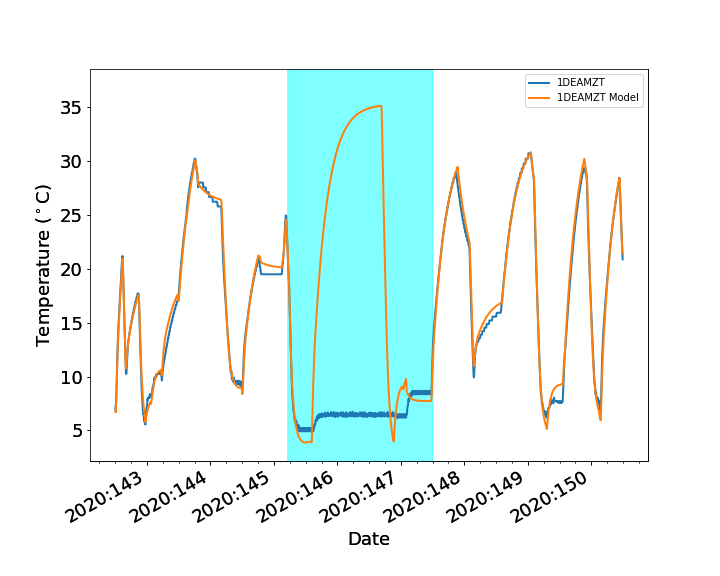

In [4]:
dp = acispy.DatePlot(dea_model, [("msids", "1deamzt"), ("model", "1deamzt")], plot_bad=True)
dp

Note that for this period of time a segment of it was marked as a "bad time" in the model, and this shows up in the cyan region in the plot. 

## Running Thermal Models Using States from Various Sources

The `ThermalModelRunner` class also has various methods which one can use to run thermal models using states from various sources.

### Running a Thermal Model from Commands

You can use a set of commands (either a `kadi` `CommandTable` or list of command dicts) to run a thermal model using the `from_commands` method:

In [5]:
from kadi import commands
# commands as a CommandTable
cmds = commands.get_cmds('2018:001:00:00:00', '2018:002:00:00:00')
psmc_model = acispy.ThermalModelRunner.from_commands("1pdeaat", cmds)
# commands as a list of dicts
dict_cmds = cmds.as_list_of_dict()
psmc_model2 = acispy.ThermalModelRunner.from_commands("1pdeaat", dict_cmds)

### Running a Thermal Model from a Backstop File

You can use a backstop file as input to `ThermalModelRunner` to generate states for a thermal model run. In this case, `ThermalModelRunner` will go back to the latest telemetry to determine the initial temperature (unless one is specified, see below) and construct states from that point and handle continuity between those and the commands in the backstop file appropriately. To show this, we'll use the ACA thermal model, which requires that the initial value for the `aca0` pseudonode be specified, which we can do using the `other_init` keyword argument:

In [6]:
tm_aca = acispy.ThermalModelRunner.from_backstop(
    "aacccdpt", "/data/acis/LoadReviews/2020/AUG1720/ofls/CR229_2202.backstop",
    other_init={"aca0": -10})

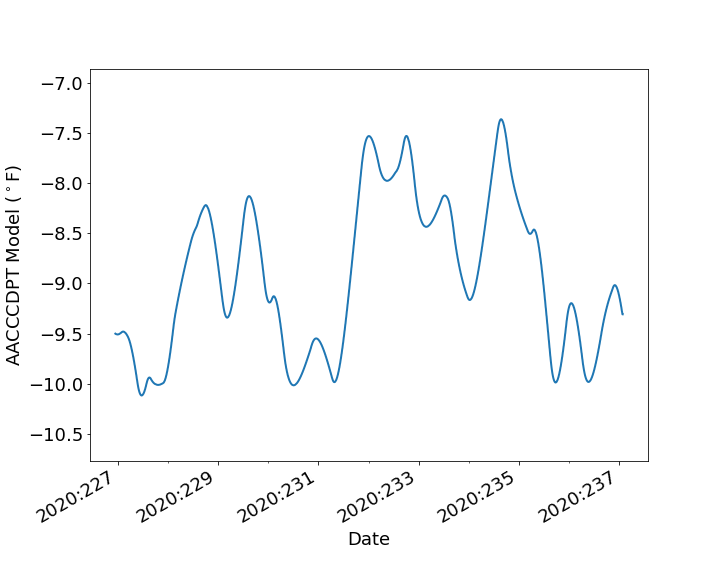

In [7]:
dp = acispy.DatePlot(tm_aca, ('model','aacccdpt'))
dp

### Running a Thermal Model Using a `states.dat` File

One can run a thermal model from a `states.dat` table file which would be outputted by the thermal model check scripts during a load review, using the `from_states_file()` method:

In [8]:
dpa_model = acispy.ThermalModelRunner.from_states_file("1dpamzt", "my_states.dat")

### Running Thermal Models Using States Constructed By Hand

You can create a dictionary of states completely by hand and submit them as a keyword argument to `ThermalModelRunner`, for running completely hypothetical thermal models. For simplicity, we'll pick constant states except change the CCD count.

In [9]:
states = {"ccd_count": np.array([5,6,1]),
          "pitch": np.array([150.0]*3),
          "fep_count": np.array([5,6,1]),
          "clocking": np.array([1]*3),
          "vid_board": np.array([1]*3),
          "off_nom_roll": np.array([0.0]*3),
          "simpos": np.array([-99616.0]*3),
          "datestart": np.array(["2015:002:00:00:00","2015:002:12:00:00","2015:003:12:00:00"]),
          "datestop": np.array(["2015:002:12:00:00","2015:003:12:00:00","2015:005:00:00:00"])}

In the previous examples, we never specified an initial temperature, but we can always do so, and must do so if we are past the end value in telemetry. This is not the case here, but we'll set one anyway:

In [10]:
T_init = 13.0 # in degrees C

Now we can pass in the `states` dict we created, as well as the `T_init`:

In [11]:
dea_model = acispy.ThermalModelRunner("1deamzt", "2015:002:00:00:00", 
                                      "2015:005:00:00:00", states=states, T_init=T_init)

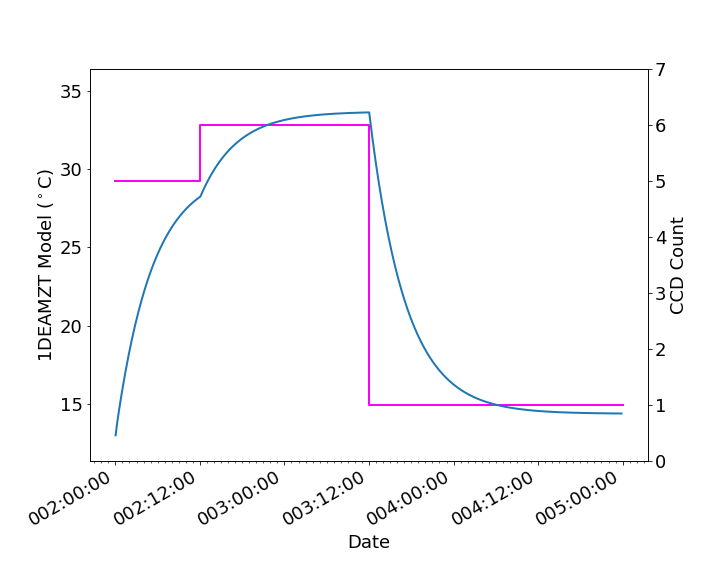

In [12]:
dp = acispy.DatePlot(dea_model, ("model","1deamzt"), field2="ccd_count")
dp.set_ylim2(0,7)
dp

We can also dump the results of the model run to disk, both the states and the model components:

In [13]:
dea_model.write_model("model.dat", overwrite=True)
dea_model.write_states("states.dat", overwrite=True)

These files can be loaded in at a later date using `ModelDataFromFiles`.

## Making Dashboard Plots

### NOTE: This functionality requires the `xijafit` package to be installed. 

It is possible to use the thermal model objects and the `xijafit` package to make dashboard plots. For this, use the `make_dashboard_plots()` method:

Fetching msid: sim_z over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: pitch over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: roll over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Getting kadi commanded states over 2016:200:12:01:27.816 to 2017:200:11:51:50.816
Fetching msid: dp_dpa_power over 2016:200:11:34:07.816 to 2017:200:12:19:10.816


acispy: [WARNING  ] 2020-08-21 10:42:20,966 Cannot find a unit for MSID off_nominal_roll. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:20,968 Cannot find a unit for MSID fep_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:20,970 Cannot find a unit for MSID vid_board. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:20,972 Cannot find a unit for MSID clocking. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:20,974 Cannot find a unit for MSID ccd_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:20,976 Cannot find a unit for MSID simpos. Setting to dimensionless.


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


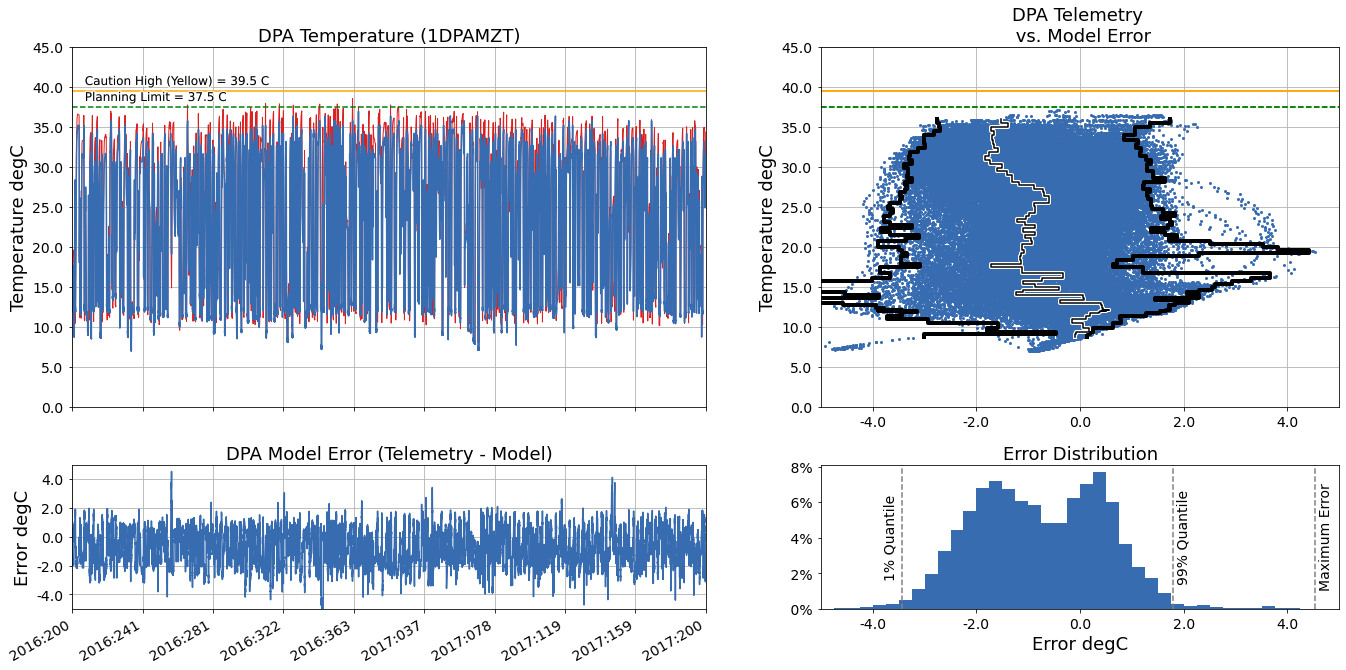

In [14]:
dpa_model_long = acispy.ThermalModelRunner("1dpamzt", "2016:200", "2017:200", 
                                           mask_bad_times=True, get_msids=True)
dpa_model_long.make_dashboard_plots("1dpamzt", figfile="my_dpa_dash.png")

`figfile` sets the filename to save the dashboard plot to.

One can also use the `errorplotlimits` and `yplotlimits` arguments to set the bounds of the temperature and the errors on the plots:

Fetching msid: 1cbat over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: pitch over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: roll over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: 1dahtbon over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: sim_z over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Getting kadi commanded states over 2016:200:12:01:27.816 to 2017:200:11:51:50.816
Fetching msid: dp_dpa_power over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: orbitephem0_x over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: orbitephem0_y over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: orbitephem0_z over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: aoattqt1 over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: aoattqt2 over 2016:200:11:34:07.816 to 2017:200:12:19:10.816
Fetching msid: aoattqt3 over 2016:200:11:34:07.816 to 2017:200:12:19:10.816


acispy: [WARNING  ] 2020-08-21 10:42:55,459 Cannot find a unit for MSID off_nominal_roll. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:55,461 Cannot find a unit for MSID fep_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:55,463 Cannot find a unit for MSID vid_board. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:55,465 Cannot find a unit for MSID clocking. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:55,467 Cannot find a unit for MSID ccd_count. Setting to dimensionless.
acispy: [WARNING  ] 2020-08-21 10:42:55,469 Cannot find a unit for MSID simpos. Setting to dimensionless.


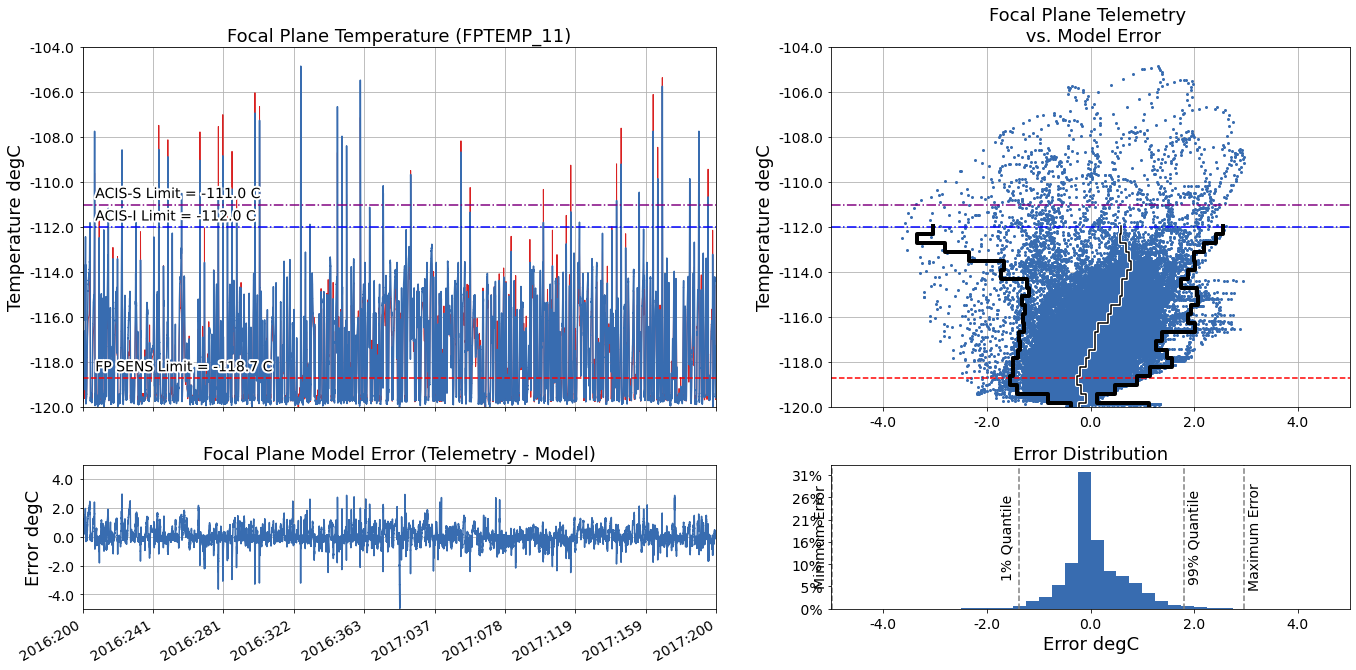

In [15]:
fp_model_long = acispy.ThermalModelRunner("fptemp_11", "2016:200", "2017:200", 
                                          mask_bad_times=True, get_msids=True)
fp_model_long.make_dashboard_plots("fptemp_11", yplotlimits=(-120.0, -104.0), 
                                   errorplotlimits=(-5.0, 5.0))

## Plotting Pitch and State Power Heating Values

All thermal models have a solar heating component. To make a quick solar heating plot, use the `make_solarheat_plot` method, with the node that the solar heating component acts upon as the first argument. 

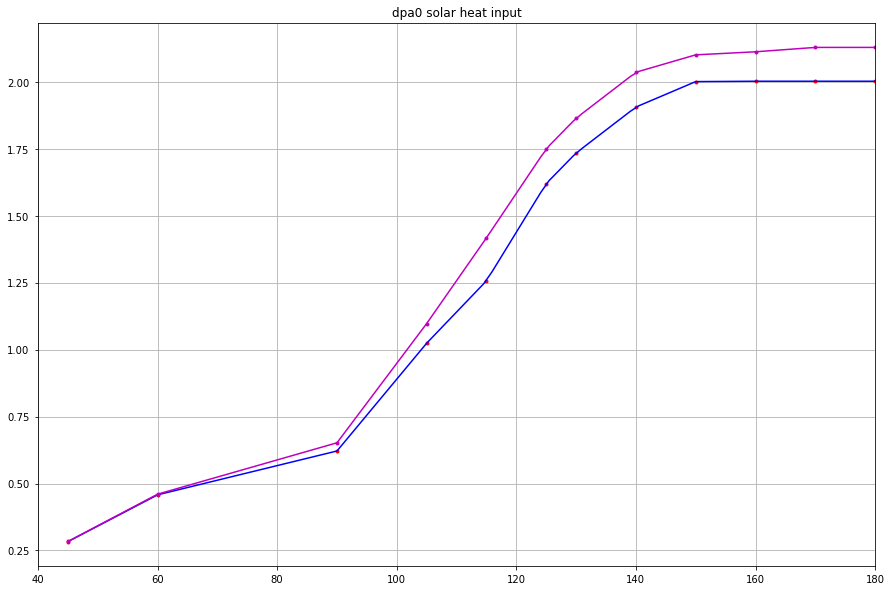

In [16]:
dpa_model_long.make_solarheat_plot("dpa0", figfile="dpa0_pitches.png")

Similarly, to plot the ACIS state power coefficients for the model, use the `make_power_plot` method:

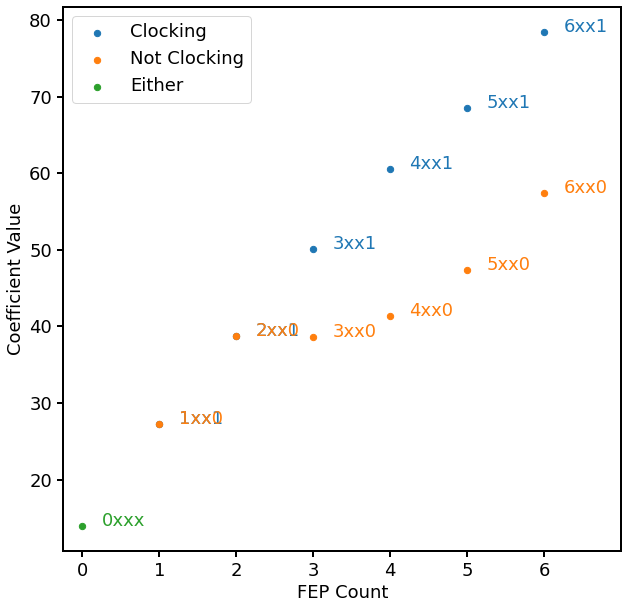

In [17]:
# For the 1DEAMZT model set use_ccd_count=True
dpa_model_long.make_power_plot(figfile="acis_state_power.png", use_ccd_count=False)

## Simulating ECS Runs

A special case of running a thermal model in ACISpy is simulating an ECS run, which may be performed after a safing action. The `SimulateECSRun` class simplifies the call to `ThermalModelRunner` by assuming that the state is constant over a period of time (unless a vehicle load is running, see below). The goal is to predict if the temperature will hit the planning limit within the time frame of the ECS run.
To run this model, we only need specify a few parameters (some of which are optional and have default values):

In [18]:
datestart = "2015:002:00:00:00" # start time of run
hours = 24 # length of ECS run in hours
pitch = 136. # in degrees
T_init = 7.5 # in degrees C
ccd_count = 6 # number of CCDs
simpos = -99616.0 # SIM-Z position, optional, default -99616.0
off_nom_roll = 0.0 # in degrees, optional, default 0.0
dh_heater = 0 # is the detector housing heater on (1) or off (0)? default 0

We pick a model to run (most relevant is `"dpa"`) along with a start time a length of the ECS run in hours (24 in this case), and feed them and the above parameters into `SimulateECSRun`:

In [19]:
dpa_ecs_run = acispy.SimulateECSRun("1dpamzt", datestart, hours, T_init, pitch, ccd_count, 
                                    simpos=simpos, off_nom_roll=off_nom_roll, dh_heater=dh_heater)

acispy: [INFO     ] 2020-08-21 10:42:59,492 Run Parameters
acispy: [INFO     ] 2020-08-21 10:42:59,493 --------------
acispy: [INFO     ] 2020-08-21 10:42:59,494 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2020-08-21 10:42:59,494 Length of ECS run in hours: 24
acispy: [INFO     ] 2020-08-21 10:42:59,495 Stop Datestring: 2015:003:02:46:52.000
acispy: [INFO     ] 2020-08-21 10:42:59,496 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2020-08-21 10:42:59,497 CCD Count: 6
acispy: [INFO     ] 2020-08-21 10:42:59,498 FEP Count: 6
acispy: [INFO     ] 2020-08-21 10:42:59,498 Pitch: 136.0
acispy: [INFO     ] 2020-08-21 10:42:59,499 SIM Position: -99616
acispy: [INFO     ] 2020-08-21 10:42:59,500 Off-nominal Roll: 0.0
acispy: [INFO     ] 2020-08-21 10:42:59,501 Detector Housing Heater: OFF
acispy: [INFO     ] 2020-08-21 10:42:59,502 Model Result
acispy: [INFO     ] 2020-08-21 10:42:59,503 ------------
acispy: [INFO     ] 2020-08-21 10:42:59,505 The limit of 37.5 degrees C 

*NOTE* that the actual length of the ECS run, as per the ECS CAP, is `hours`+ 10 ks + 12 s. 

The run reports back the input parameters and the time when the limit was reached, if it was at all. We can plot the model using the `plot_model()` method, 
which shows the limit value as a dashed green line and the time at which the limit was reached as a dashed red line:

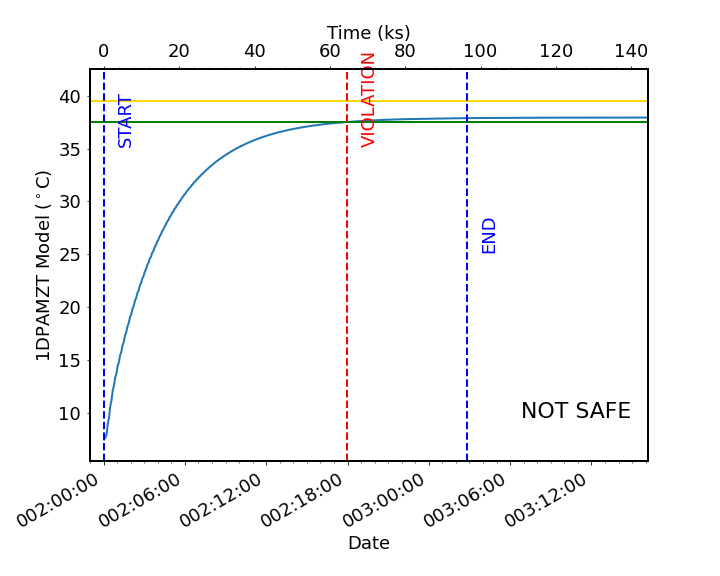

In [20]:
dpa_ecs_run.plot_model()

On the other hand, if the ECS run had been shorter, the limit would be reached _after_ the ECS run, so this is safe.

acispy: [INFO     ] 2020-08-21 10:43:00,483 Run Parameters
acispy: [INFO     ] 2020-08-21 10:43:00,484 --------------
acispy: [INFO     ] 2020-08-21 10:43:00,484 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2020-08-21 10:43:00,485 Length of ECS run in hours: 14
acispy: [INFO     ] 2020-08-21 10:43:00,489 Stop Datestring: 2015:002:16:46:52.000
acispy: [INFO     ] 2020-08-21 10:43:00,491 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2020-08-21 10:43:00,492 CCD Count: 6
acispy: [INFO     ] 2020-08-21 10:43:00,495 FEP Count: 6
acispy: [INFO     ] 2020-08-21 10:43:00,495 Pitch: 136.0
acispy: [INFO     ] 2020-08-21 10:43:00,496 SIM Position: -99616
acispy: [INFO     ] 2020-08-21 10:43:00,497 Off-nominal Roll: 0.0
acispy: [INFO     ] 2020-08-21 10:43:00,498 Detector Housing Heater: OFF
acispy: [INFO     ] 2020-08-21 10:43:00,499 Model Result
acispy: [INFO     ] 2020-08-21 10:43:00,500 ------------
acispy: [INFO     ] 2020-08-21 10:43:00,501 The limit of 37.5 degrees C 

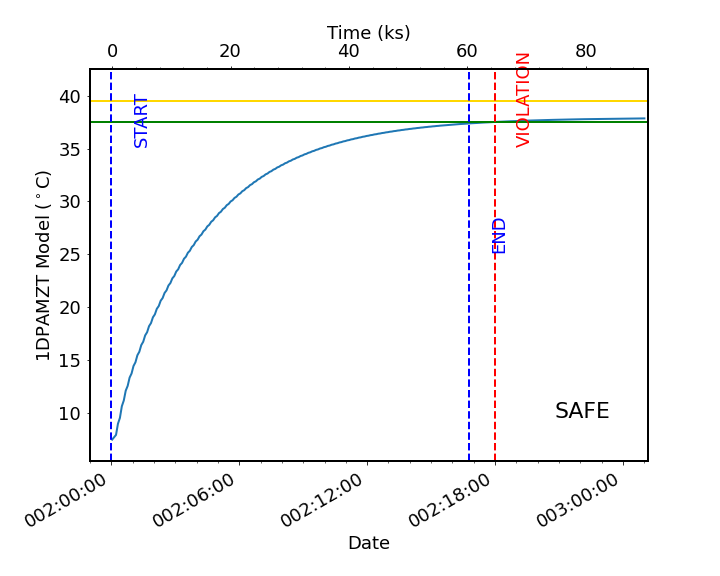

In [21]:
hours = 14
dpa_ecs_run = acispy.SimulateECSRun("1dpamzt", datestart, hours, T_init, pitch, ccd_count, 
                                    simpos=simpos, off_nom_roll=off_nom_roll, dh_heater=dh_heater)
dpa_ecs_run.plot_model()

Note that for some combinations of parameters the limit may never be reached. For example, let's knock the CCD count down to 4:

acispy: [INFO     ] 2020-08-21 10:43:01,083 Run Parameters
acispy: [INFO     ] 2020-08-21 10:43:01,084 --------------
acispy: [INFO     ] 2020-08-21 10:43:01,085 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2020-08-21 10:43:01,085 Length of ECS run in hours: 14
acispy: [INFO     ] 2020-08-21 10:43:01,086 Stop Datestring: 2015:002:16:46:52.000
acispy: [INFO     ] 2020-08-21 10:43:01,087 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2020-08-21 10:43:01,087 CCD Count: 4
acispy: [INFO     ] 2020-08-21 10:43:01,088 FEP Count: 4
acispy: [INFO     ] 2020-08-21 10:43:01,088 Pitch: 136.0
acispy: [INFO     ] 2020-08-21 10:43:01,089 SIM Position: -99616
acispy: [INFO     ] 2020-08-21 10:43:01,089 Off-nominal Roll: 0.0
acispy: [INFO     ] 2020-08-21 10:43:01,090 Detector Housing Heater: OFF
acispy: [INFO     ] 2020-08-21 10:43:01,091 Model Result
acispy: [INFO     ] 2020-08-21 10:43:01,092 ------------
acispy: [INFO     ] 2020-08-21 10:43:01,093 The limit of 37.5 degrees C 

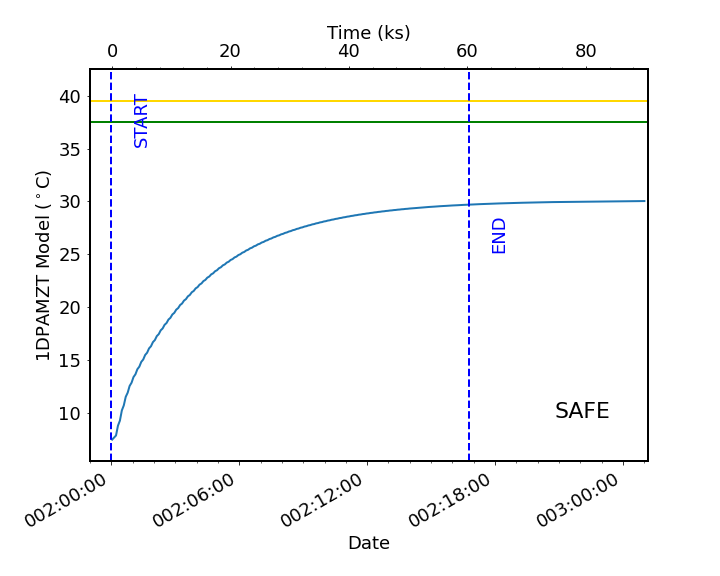

In [22]:
ccd_count = 4 # only 4 CCDs
dpa_ecs_run = acispy.SimulateECSRun("1dpamzt", datestart, hours, T_init, pitch, ccd_count, 
                                    simpos=simpos, off_nom_roll=off_nom_roll, dh_heater=dh_heater)
dpa_ecs_run.plot_model()

### Simulating ECS Runs with Vehicle Loads

If the spacecraft executed SCS-107, we may be running an ECS run while the vehicle load is still running, which means that the pitch and off-nominal roll may change during the ECS run. If this is the case, pass the name of the load to the ``vehicle_load`` parameter. You still need to input the value of the ``pitch`` parameter, but the value of this parameter and that of the ``off_nom_roll`` optional parameter will be ignored in favor of the value in the vehicle load. An example of an ECS run that is not safe:

acispy: [INFO     ] 2020-08-21 10:43:01,565 Modeling a 6-chip observation concurrent with the SEP0917C vehicle loads.
acispy: [INFO     ] 2020-08-21 10:43:02,815 Run Parameters
acispy: [INFO     ] 2020-08-21 10:43:02,816 --------------
acispy: [INFO     ] 2020-08-21 10:43:02,816 Start Datestring: 2017:256:03:20:00.000
acispy: [INFO     ] 2020-08-21 10:43:02,817 Length of ECS run in hours: 24
acispy: [INFO     ] 2020-08-21 10:43:02,817 Stop Datestring: 2017:257:06:06:52.000
acispy: [INFO     ] 2020-08-21 10:43:02,818 Initial Temperature: 12 degrees C
acispy: [INFO     ] 2020-08-21 10:43:02,819 CCD Count: 6
acispy: [INFO     ] 2020-08-21 10:43:02,819 FEP Count: 6
acispy: [INFO     ] 2020-08-21 10:43:02,820 Pitch: Min: 46.56, Max: 156
acispy: [INFO     ] 2020-08-21 10:43:02,821 SIM Position: -99616
acispy: [INFO     ] 2020-08-21 10:43:02,822 Off-nominal Roll: Min: -12.5116, Max: 13.7689
acispy: [INFO     ] 2020-08-21 10:43:02,823 Detector Housing Heater: OFF
acispy: [INFO     ] 2020-08-21

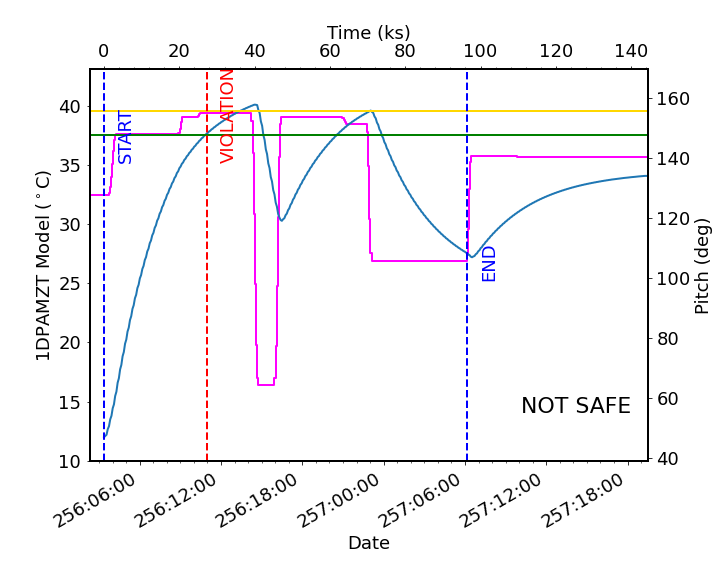

In [23]:
datestart = "2017:256:03:20:00"
hours = 24
pitch = 0.0 # Doesn't matter what this is
T_init = 12.0 # in degrees C
ccd_count = 6 # number of CCDs 
dpa_ecs_run = acispy.SimulateECSRun("1dpamzt", datestart, hours, T_init, pitch, ccd_count, 
                                    vehicle_load="SEP0917C")
dpa_ecs_run.plot_model()

But if we drop it down to 5 chips, it is safe:

acispy: [INFO     ] 2020-08-21 10:43:03,549 Modeling a 5-chip observation concurrent with the SEP0917C vehicle loads.
acispy: [INFO     ] 2020-08-21 10:43:04,659 Run Parameters
acispy: [INFO     ] 2020-08-21 10:43:04,660 --------------
acispy: [INFO     ] 2020-08-21 10:43:04,660 Start Datestring: 2017:256:03:20:00.000
acispy: [INFO     ] 2020-08-21 10:43:04,660 Length of ECS run in hours: 24
acispy: [INFO     ] 2020-08-21 10:43:04,661 Stop Datestring: 2017:257:06:06:52.000
acispy: [INFO     ] 2020-08-21 10:43:04,661 Initial Temperature: 12 degrees C
acispy: [INFO     ] 2020-08-21 10:43:04,662 CCD Count: 5
acispy: [INFO     ] 2020-08-21 10:43:04,663 FEP Count: 5
acispy: [INFO     ] 2020-08-21 10:43:04,663 Pitch: Min: 46.56, Max: 156
acispy: [INFO     ] 2020-08-21 10:43:04,663 SIM Position: -99616
acispy: [INFO     ] 2020-08-21 10:43:04,664 Off-nominal Roll: Min: -12.5116, Max: 13.7689
acispy: [INFO     ] 2020-08-21 10:43:04,664 Detector Housing Heater: OFF
acispy: [INFO     ] 2020-08-21

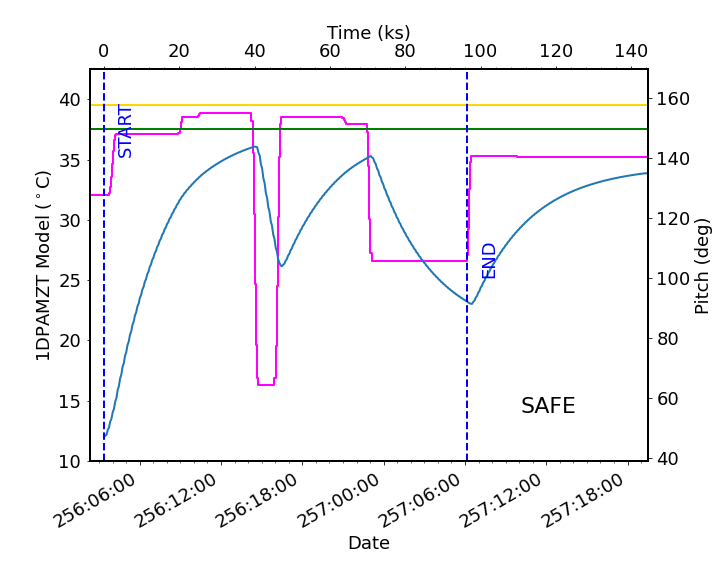

In [24]:
ccd_count = 5 # number of CCDs 
dpa_ecs_run = acispy.SimulateECSRun("1dpamzt", datestart, hours, T_init, pitch, ccd_count, 
                                    vehicle_load="SEP0917C")
dpa_ecs_run.plot_model()